<a href="https://colab.research.google.com/github/samratkar/samratkar.github.io/blob/main/Copy_of_LLM_Prod_RAG_Chunking_Strategies_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vizuara AI Labs: RAG Chunking Strategies

## Step 0: Load packages

In [ ]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    #!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
   # !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 117.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=256040057 sha256=f25da18657a87fc83dc1bfb8b7751b82246e9db355510226b674fd437c34b5fb
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


## Step 1: Download PDF file

In [ ]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File doesn't exist, downloading...
The file has been downloaded and saved as human-nutrition-text.pdf


## Step 2: Open and read PDF file

In [ ]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

## Step 3: Testing 5 chunking strategies: fixed, recursive, semantic, structural and LLM based.

## Chunking Strategy 1: Fixed size chunking

In [ ]:
def chunk_text(text: str, chunk_size: int = 500) -> list:
    """
    Splits text into chunks of approx. `chunk_size` characters.
    """
    chunks = []
    current_chunk = ''
    words = text.split()

    for word in words:
        # Check if adding the word exceeds chunk size
        if len(current_chunk) + len(word) + 1 <= chunk_size:
            current_chunk += (word + ' ')
        else:
            # Store current chunk and start new one
            chunks.append(current_chunk.strip())
            current_chunk = word + ' '

    # Add the last chunk if not empty
    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks


def chunk_pdf_pages(pages_and_texts: list, chunk_size: int = 500) -> list[dict]:
    """
    Takes PDF pages with text and splits them into chunks.

    Returns a list of dicts with page_number, chunk_index, and chunk_text.
    """
    all_chunks = []
    for page in pages_and_texts:
        page_number = page["page_number"]
        page_text = page["text"]

        chunks = chunk_text(page_text, chunk_size=chunk_size)
        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_char_count": len(chunk),
                "chunk_word_count": len(chunk.split()),
                "chunk_token_count": len(chunk) / 4,  # rough token estimate
                "chunk_text": chunk
            })
    return all_chunks


# Example usage
chunked_pages = chunk_pdf_pages(pages_and_texts, chunk_size=500)
print(f"Total chunks: {len(chunked_pages)}")
print(f"First chunk (page {chunked_pages[0]['page_number']}): {chunked_pages[0]['chunk_text'][:200]}...")


Total chunks: 3321
First chunk (page -41): Human Nutrition: 2020 Edition...


In [ ]:
import random, textwrap

# ---------- Sampling & Pretty Printing ----------
def _scattered_indices(n: int, k: int, jitter_frac: float = 0.08) -> list[int]:
    """Evenly spaced anchors + random jitter → indices scattered across [0, n-1]."""
    if k <= 0:
        return []
    if k == 1:
        return [random.randrange(n)]
    anchors = [int(round(i * (n - 1) / (k - 1))) for i in range(k)]
    out, seen = [], set()
    radius = max(1, int(n * jitter_frac))
    for a in anchors:
        lo, hi = max(0, a - radius), min(n - 1, a + radius)
        j = random.randint(lo, hi)
        if j not in seen:
            out.append(j); seen.add(j)
    while len(out) < k:
        r = random.randrange(n)
        if r not in seen:
            out.append(r); seen.add(r)
    return out

def _draw_boxed_chunk(c: dict, wrap_at: int = 96) -> str:
    header = (
        f" Chunk p{c['page_number']} · idx {c['chunk_index']}  |  "
        f"chars {c['chunk_char_count']} · words {c['chunk_word_count']} · ~tokens {c['chunk_token_count']} "
    )
    # Wrap body text, avoid breaking long words awkwardly
    wrapped_lines = textwrap.wrap(
        c["chunk_text"], width=wrap_at, break_long_words=False, replace_whitespace=False
    )
    content_width = max([0, *map(len, wrapped_lines)])
    box_width = max(len(header), content_width + 2)  # +2 for side padding

    top    = "╔" + "═" * box_width + "╗"
    hline  = "║" + header.ljust(box_width) + "║"
    sep    = "╟" + "─" * box_width + "╢"
    body   = "\n".join("║ " + line.ljust(box_width - 2) + " ║" for line in wrapped_lines) or \
             ("║ " + "".ljust(box_width - 2) + " ║")
    bottom = "╚" + "═" * box_width + "╝"
    return "\n".join([top, hline, sep, body, bottom])

def show_random_chunks(pages_and_texts: list, chunk_size: int = 500, k: int = 5, seed: int | None = 42):
    if seed is not None:
        random.seed(seed)
    all_chunks = chunk_pdf_pages(pages_and_texts, chunk_size=chunk_size)
    if not all_chunks:
        print("No chunks to display.");
        return
    idxs = _scattered_indices(len(all_chunks), k)
    print(f"Showing {len(idxs)} scattered random chunks out of {len(all_chunks)} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(all_chunks[idx]))
        print()

# ---------- Run ----------
assert 'pages_and_texts' in globals(), "Run: pages_and_texts = open_and_read_pdf(pdf_path) first."
show_random_chunks(pages_and_texts, chunk_size=500, k=5, seed=42)

Showing 5 scattered random chunks out of 3321 total:

#1
╔══════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Chunk p-9 · idx 0  |  chars 290 · words 49 · ~tokens 72.5                                        ║
╟──────────────────────────────────────────────────────────────────────────────────────────────────╢
║ Skylar Hara Skylar Hara is an undergraduate student student in the Tropical Agriculture and the  ║
║ Environment program at the University of Hawai‘i at Mānoa. She has a growing love for plants and ║
║ hopes to go to graduate school to conduct research in the future. About the Contributors |       ║
║ xxxiii                                                                                           ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════╝

#2
╔═════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Chunk p198 · idx 0  |  chars 

## Chunking Strategy 2: Semantic chunking

In [ ]:
!pip -q install --upgrade "sentence-transformers==3.0.1" "transformers<5,>=4.41" scikit-learn nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 60.1 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
nltk.download('punkt', quiet=True)

# Load once globally
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

def semantic_chunk_text(text: str, similarity_threshold: float = 0.8, max_tokens: int = 500) -> list:
    """
    Splits text into semantic chunks based on sentence similarity and max token length.
    """
    sentences = nltk.sent_tokenize(text)
    if not sentences:
        return []

    embeddings = semantic_model.encode(sentences)

    chunks = []
    current_chunk = [sentences[0]]
    current_embedding = embeddings[0]

    for i in range(1, len(sentences)):
        sim = cosine_similarity([current_embedding], [embeddings[i]])[0][0]
        chunk_token_count = len(" ".join(current_chunk)) // 4

        if sim >= similarity_threshold and chunk_token_count < max_tokens:
            current_chunk.append(sentences[i])
            current_embedding = np.mean([current_embedding, embeddings[i]], axis=0)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentences[i]]
            current_embedding = embeddings[i]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


from tqdm.auto import tqdm

def semantic_chunk_pdf_pages(pages_and_texts: list,
                             similarity_threshold: float = 0.8,
                             max_tokens: int = 500) -> list[dict]:
    """
    Takes PDF pages with text and splits them into semantic chunks.

    Returns a list of dicts with page_number, chunk_index, and chunk_text.
    """
    all_chunks = []

    for page in tqdm(pages_and_texts, desc="Semantic chunking pages"):
        page_number = page["page_number"]
        page_text = page["text"]

        chunks = semantic_chunk_text(page_text,
                                     similarity_threshold=similarity_threshold,
                                     max_tokens=max_tokens)
        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_char_count": len(chunk),
                "chunk_word_count": len(chunk.split()),
                "chunk_token_count": len(chunk) / 4,  # rough token estimate
                "chunk_text": chunk
            })
    return all_chunks




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import nltk
nltk.download('punkt_tab')
semantic_chunked_pages = semantic_chunk_pdf_pages(pages_and_texts,
                                                  similarity_threshold=0.75,
                                                  max_tokens=500)

print(f"Total semantic chunks: {len(semantic_chunked_pages)}")
print(f"First semantic chunk (page {semantic_chunked_pages[0]['page_number']}):")
print(semantic_chunked_pages[0]['chunk_text'][:200] + "...")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Semantic chunking pages:   0%|          | 0/1208 [00:00<?, ?it/s]

Total semantic chunks: 12016
First semantic chunk (page -41):
Human Nutrition: 2020 Edition...


In [ ]:
# Pretty-print 5 random SEMANTIC chunks (uses `semantic_chunked_pages` from your code above)

import random
import textwrap

def _scattered_indices(n: int, k: int, jitter_frac: float = 0.08) -> list[int]:
    """Evenly spaced anchors + random jitter → indices scattered across [0, n-1]."""
    if k <= 0:
        return []
    if k == 1:
        return [random.randrange(n)]
    anchors = [int(round(i * (n - 1) / (k - 1))) for i in range(k)]
    out, seen = [], set()
    radius = max(1, int(n * jitter_frac))
    for a in anchors:
        lo, hi = max(0, a - radius), min(n - 1, a + radius)
        j = random.randint(lo, hi)
        if j not in seen:
            out.append(j); seen.add(j)
    while len(out) < k:
        r = random.randrange(n)
        if r not in seen:
            out.append(r); seen.add(r)
    return out

def _draw_boxed_chunk(c: dict, wrap_at: int = 96) -> str:
    approx_tokens = c.get('chunk_token_count', len(c.get('chunk_text', ''))/4)
    header = (
        f" Chunk p{c['page_number']} · idx {c['chunk_index']}  |  "
        f"chars {c['chunk_char_count']} · words {c['chunk_word_count']} · ~tokens {round(approx_tokens, 2)} "
    )
    wrapped_lines = textwrap.wrap(
        c["chunk_text"], width=wrap_at, break_long_words=False, replace_whitespace=False
    )
    content_width = max([0, *map(len, wrapped_lines)])
    box_width = max(len(header), content_width + 2)  # +2 for side padding

    top    = "╔" + "═" * box_width + "╗"
    hline  = "║" + header.ljust(box_width) + "║"
    sep    = "╟" + "─" * box_width + "╢"
    body   = "\n".join("║ " + line.ljust(box_width - 2) + " ║" for line in wrapped_lines) or \
             ("║ " + "".ljust(box_width - 2) + " ║")
    bottom = "╚" + "═" * box_width + "╝"
    return "\n".join([top, hline, sep, body, bottom])

def show_random_semantic_chunks(semantic_chunked_pages: list[dict], k: int = 5, seed: int | None = 42):
    if seed is not None:
        random.seed(seed)
    n = len(semantic_chunked_pages)
    if n == 0:
        print("No semantic chunks to display.");
        return
    idxs = _scattered_indices(n, k)
    print(f"Showing {len(idxs)} scattered random SEMANTIC chunks out of {n} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(semantic_chunked_pages[idx]))
        print()

# --- Run (expects you've already created `semantic_chunked_pages`) ---
assert 'semantic_chunked_pages' in globals() and len(semantic_chunked_pages) > 0, \
    "Run your semantic chunking code first to define `semantic_chunked_pages`."
show_random_semantic_chunks(semantic_chunked_pages, k=5, seed=42)


Showing 5 scattered random SEMANTIC chunks out of 12016 total:

#1
╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║ Chunk p56 · idx 7  |  chars 200 · words 31 · ~tokens 50.0                                    ║
╟──────────────────────────────────────────────────────────────────────────────────────────────╢
║ Observing the connection  between the beverage and longevity, Dr. Elie Metchnikoff began his ║
║ research on beneficial bacteria and the longevity of life that led to  his book, The         ║
║ Prolongation of Life.                                                                        ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

#2
╔════════════════════════════════════════════════════════════════════════════════════╗
║ Chunk p232 · idx 7  |  chars 82 · words 12 · ~tokens 20.5                          ║
╟───────────────────────────────────────────────────────────────────────────

## Chunking strategy 3: Recursive chunking

### Understanding Recursive Chunking

Recursive chunking is a strategy for splitting long text into smaller, manageable pieces while preserving the natural structure of the text as much as possible. Instead of splitting arbitrarily, it tries progressively larger-to-smaller breaks: sections, then paragraphs, then sentences.

---

#### How It Works

1. **Check the block size**: If the block is already small enough (below `max_chunk_size`), keep it as is.
2. **Split by big breaks first**: If it is too long, try splitting by double newlines (`\n\n`), which usually represent sections.
3. **If still too long, split further**: If the section is still too big, split by single newlines (`\n`), which usually represent paragraphs.
4. **Fallback to sentences**: If the paragraph is still too large, split into individual sentences using a sentence tokenizer.
5. **Repeat recursively**: Each new sub-chunk is checked again until all pieces are under the size limit.

---

#### Example

Consider this text:

```
SECTION 1

This is the first paragraph. It has two sentences. Here is the second sentence.

This is the second paragraph. It also has two sentences. Another sentence is here.

SECTION 2

This section has only one short paragraph. That's all.
```

Suppose `max_chunk_size = 50` characters.

**Step 1: Split whole text**

* The entire text is larger than 50, so it is split by double newlines into three parts:

  1. "SECTION 1"
  2. "This is the first paragraph... Another sentence is here."
  3. "SECTION 2 ... That's all."

**Step 2: Process each part**

* *Chunk 1*: "SECTION 1" is under 50 characters → keep as is.
* *Chunk 2*: Too long → split by single newlines into two paragraphs. Each paragraph is still too long, so each is split further into sentences.
* *Chunk 3*: Splits into "SECTION 2" and "This section has only one short paragraph. That's all." Both are under 50 characters.

**Final Chunks:**

1. "SECTION 1"
2. "This is the first paragraph."
3. "It has two sentences."
4. "Here is the second sentence."
5. "This is the second paragraph."
6. "It also has two sentences."
7. "Another sentence is here."
8. "SECTION 2"
9. "This section has only one short paragraph. That's all."

---

#### Key Points

* Recursive chunking prioritizes natural text boundaries: section > paragraph > sentence.
* It only splits further when necessary to respect the size constraint.
* Compared to fixed-size chunking, it avoids breaking words mid-way and produces more coherent chunks.


In [ ]:
import nltk
from tqdm.auto import tqdm
nltk.download("punkt")

def recursive_chunk_text(text: str, max_chunk_size: int = 1000, min_chunk_size: int = 100) -> list:
    """
    Recursively splits a block of text into chunks that fit within size constraints.
    Tries splitting by sections, then newlines, then sentences.
    """
    def split_chunk(chunk: str) -> list:
        #  Base case
        if len(chunk) <= max_chunk_size:
            return [chunk]

        #  Try splitting by double newlines
        sections = chunk.split("\n\n")
        if len(sections) > 1:
            result = []
            for section in sections:
                if section.strip():
                    result.extend(split_chunk(section.strip()))
            return result

        # Try splitting by single newline
        sections = chunk.split("\n")
        if len(sections) > 1:
            result = []
            for section in sections:
                if section.strip():
                    result.extend(split_chunk(section.strip()))
            return result

        # Fallback: split by sentences
        sentences = nltk.sent_tokenize(chunk)
        chunks, current_chunk, current_size = [], [], 0

        for sentence in sentences:
            if current_size + len(sentence) > max_chunk_size:
                if current_chunk:
                    chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_size = len(sentence)
            else:
                current_chunk.append(sentence)
                current_size += len(sentence)

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        return chunks

    return split_chunk(text)


def recursive_chunk_pdf_pages(pages_and_texts: list,
                              max_chunk_size: int = 1000,
                              min_chunk_size: int = 100) -> list[dict]:
    """
    Takes PDF pages with text and splits them into recursive chunks.

    Returns a list of dicts with page_number, chunk_index, and chunk_text.
    """
    all_chunks = []

    for page in tqdm(pages_and_texts, desc="Recursive chunking pages"):
        page_number = page["page_number"]
        page_text = page["text"]

        chunks = recursive_chunk_text(page_text,
                                      max_chunk_size=max_chunk_size,
                                      min_chunk_size=min_chunk_size)
        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_char_count": len(chunk),
                "chunk_word_count": len(chunk.split()),
                "chunk_token_count": len(chunk) / 4,  # rough token estimate
                "chunk_text": chunk
            })
    return all_chunks


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
recursive_chunked_pages = recursive_chunk_pdf_pages(pages_and_texts,
                                                    max_chunk_size=800,
                                                    min_chunk_size=100)

print(f"Total recursive chunks: {len(recursive_chunked_pages)}")
print(f"First recursive chunk (page {recursive_chunked_pages[0]['page_number']}):")
print(recursive_chunked_pages[0]['chunk_text'][:200] + "...")


Recursive chunking pages:   0%|          | 0/1208 [00:00<?, ?it/s]

Total recursive chunks: 2434
First recursive chunk (page -41):
Human Nutrition: 2020 Edition...


In [ ]:
# Pretty-print 5 random RECURSIVE chunks (uses `recursive_chunked_pages` from your code above)

import random
import textwrap

def _scattered_indices(n: int, k: int, jitter_frac: float = 0.08) -> list[int]:
    """Evenly spaced anchors + random jitter → indices scattered across [0, n-1]."""
    if k <= 0:
        return []
    if k == 1:
        return [random.randrange(n)]
    anchors = [int(round(i * (n - 1) / (k - 1))) for i in range(k)]
    out, seen = [], set()
    radius = max(1, int(n * jitter_frac))
    for a in anchors:
        lo, hi = max(0, a - radius), min(n - 1, a + radius)
        j = random.randint(lo, hi)
        if j not in seen:
            out.append(j); seen.add(j)
    while len(out) < k:
        r = random.randrange(n)
        if r not in seen:
            out.append(r); seen.add(r)
    return out

def _draw_boxed_chunk(c: dict, wrap_at: int = 96) -> str:
    approx_tokens = c.get('chunk_token_count', len(c.get('chunk_text', '')) / 4)
    header = (
        f" Chunk p{c['page_number']} · idx {c['chunk_index']}  |  "
        f"chars {c['chunk_char_count']} · words {c['chunk_word_count']} · ~tokens {round(approx_tokens, 2)} "
    )
    wrapped_lines = textwrap.wrap(
        c["chunk_text"], width=wrap_at, break_long_words=False, replace_whitespace=False
    )
    content_width = max([0, *map(len, wrapped_lines)])
    box_width = max(len(header), content_width + 2)  # +2 for side padding

    top    = "╔" + "═" * box_width + "╗"
    hline  = "║" + header.ljust(box_width) + "║"
    sep    = "╟" + "─" * box_width + "╢"
    body   = "\n".join("║ " + line.ljust(box_width - 2) + " ║" for line in wrapped_lines) or \
             ("║ " + "".ljust(box_width - 2) + " ║")
    bottom = "╚" + "═" * box_width + "╝"
    return "\n".join([top, hline, sep, body, bottom])

def show_random_recursive_chunks(recursive_chunked_pages: list[dict], k: int = 5, seed: int | None = 42):
    if seed is not None:
        random.seed(seed)
    n = len(recursive_chunked_pages)
    assert n > 0, "No recursive chunks to display. Did you run the recursive chunking cell?"
    idxs = _scattered_indices(n, k)
    print(f"Showing {len(idxs)} scattered random RECURSIVE chunks out of {n} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(recursive_chunked_pages[idx]))
        print()

# --- Run (expects you've already created `recursive_chunked_pages`) ---
assert 'recursive_chunked_pages' in globals() and len(recursive_chunked_pages) > 0, \
    "Run your recursive chunking code first to define `recursive_chunked_pages`."
show_random_recursive_chunks(recursive_chunked_pages, k=5, seed=42)


Showing 5 scattered random RECURSIVE chunks out of 2434 total:

#1
╔═══════════════════════════════════════════════════════════════════════╗
║ Chunk p53 · idx 0  |  chars 69 · words 14 · ~tokens 17.25             ║
╟───────────────────────────────────────────────────────────────────────╢
║ PART II  CHAPTER 2. THE HUMAN  BODY  Chapter 2. The Human Body  |  53 ║
╚═══════════════════════════════════════════════════════════════════════╝

#2
╔══════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Chunk p213 · idx 0  |  chars 761 · words 102 · ~tokens 190.25                                    ║
╟──────────────────────────────────────────────────────────────────────────────────────────────────╢
║ Deadly  water-borne  illnesses  decreased to  almost  nonexistent  levels in the  United  States ║
║ after  the  implementat ion of water  disinfection  methods. public water systems in the country ║
║ adhere to the standards. About  15 percent of Americ

## Chunking Strategy 4: Document Structure Based chunking

### Short Document Example for Structure-Based Chunking

**Input Text:**

```
CHAPTER 1

1.1 INTRODUCTION
Nutrition is the study of nutrients and their role in the body.
It helps maintain health and prevent disease.

1.2 CARBOHYDRATES
Carbohydrates are the main source of energy.
They include sugars, starches, and fiber.

CHAPTER 2

2.1 PROTEINS
Proteins are essential for growth, repair, and overall function of cells.
```

---

**How Structure-Based Chunking Works:**

* The function looks for **headers** such as *Chapter numbers* (e.g., "CHAPTER 1") and *section headings* (e.g., "1.1 INTRODUCTION").
* Every time it finds a header, it starts a **new chunk**.
* Text is grouped with its closest heading until the next heading is reached or the chunk size limit is exceeded.
* This preserves the **logical flow** of a textbook, where content under each heading remains together.

---

**Output Chunks (using structure-based chunking):**

**Chunk 1:**

```
CHAPTER 1
```

*Explanation:* This is identified as a top-level heading and forms its own chunk.

**Chunk 2:**

```
1.1 INTRODUCTION
Nutrition is the study of nutrients and their role in the body.
It helps maintain health and prevent disease.
```

*Explanation:* The section heading and its descriptive content are grouped into one chunk.

**Chunk 3:**

```
1.2 CARBOHYDRATES
Carbohydrates are the main source of energy.
They include sugars, starches, and fiber.
```

*Explanation:* Another section with its own heading and relevant text.

**Chunk 4:**

```
CHAPTER 2
```

*Explanation:* New chapter header detected, begins a new chunk.

**Chunk 5:**

```
2.1 PROTEINS
Proteins are essential for growth, repair, and overall function of cells.
```

*Explanation:* Section heading and its content grouped together.

---

**Key Takeaway:**

Structure-based chunking is useful for documents with a clear hierarchy (chapters, sections, subsections). Unlike fixed-size chunking, it ensures that text remains tied to its headings, improving coherence and preserving semantic meaning.


In [ ]:
# --- Chapter-based chunking (simple & fast) ---
# Assumes you've already run your base PDF code so `pages_and_texts` exists.
# We detect a new CHAPTER whenever a page contains "University of Hawai" header.
# Each chapter = pages from one header until the page before the next header.

import re
import random
import textwrap

# 1) Helper to detect "chapter start" pages
def _is_chapter_header_page(text: str) -> bool:
    # Robust to punctuation/diacritics differences; matches the recurring header
    # e.g., "UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM"
    return re.search(r"university\s+of\s+hawai", text, flags=re.IGNORECASE) is not None

def _guess_title_from_page(text: str) -> str:
    """
    Best-effort chapter title guess = the text before the 'University of Hawai' header line.
    Falls back to the first ~120 characters.
    """
    m = re.search(r"university\s+of\s+hawai", text, flags=re.IGNORECASE)
    if m:
        title = text[:m.start()].strip()
        # keep it readable
        title = re.sub(r"\s+", " ", title).strip()
        if 10 <= len(title) <= 180:
            return title
    # fallback
    t = re.sub(r"\s+", " ", text).strip()
    return t[:120] if t else "Untitled Chapter"

# 2) Build chapter chunks
def chapter_chunk_pdf_pages(pages_and_texts: list[dict]) -> list[dict]:
    """
    Returns a list of chapter chunks:
    [
      {
        'chapter_index': int,
        'title': str,
        'page_start': int,   # adjusted page number (your -41 offset)
        'page_end': int,
        'chunk_char_count': int,
        'chunk_word_count': int,
        'chunk_token_count': float,   # ~chars/4
        'chunk_text': str
      }, ...
    ]
    """
    if not pages_and_texts:
        return []

    # Find all page indices that look like the start of a chapter
    chapter_starts = []
    for i, p in enumerate(pages_and_texts):
        txt = p["text"]
        if _is_chapter_header_page(txt):
            chapter_starts.append(i)

    # If nothing detected, return empty (or treat entire doc as one chunk)
    if not chapter_starts:
        # Treat entire doc as one "chapter"
        all_text = " ".join(p["text"] for p in pages_and_texts).strip()
        return [{
            "chapter_index": 0,
            "title": _guess_title_from_page(pages_and_texts[0]["text"]),
            "page_start": pages_and_texts[0]["page_number"],
            "page_end": pages_and_texts[-1]["page_number"],
            "chunk_char_count": len(all_text),
            "chunk_word_count": len(all_text.split()),
            "chunk_token_count": round(len(all_text) / 4, 2),
            "chunk_text": all_text
        }]

    # Build chapter ranges (start -> next_start-1)
    chapter_chunks = []
    for ci, s in enumerate(chapter_starts):
        e = (chapter_starts[ci + 1] - 1) if (ci + 1 < len(chapter_starts)) else (len(pages_and_texts) - 1)
        if e < s:
            continue  # guard (shouldn't happen)

        pages = pages_and_texts[s:e + 1]
        text_concat = " ".join(p["text"] for p in pages).strip()
        title = _guess_title_from_page(pages[0]["text"])

        chapter_chunks.append({
            "chapter_index": ci,
            "title": title,
            "page_start": pages[0]["page_number"],
            "page_end": pages[-1]["page_number"],
            "chunk_char_count": len(text_concat),
            "chunk_word_count": len(text_concat.split()),
            "chunk_token_count": round(len(text_concat) / 4, 2),
            "chunk_text": text_concat
        })

    return chapter_chunks

In [ ]:
structure_chunked_pages = chapter_chunk_pdf_pages(pages_and_texts)

print(f"Total chapter-based chunks: {len(structure_chunked_pages)}")
if structure_chunked_pages:
    first = structure_chunked_pages[0]
    print(f"First chapter (pages {first['page_start']}–{first['page_end']}): {first['title']}")
    print(first['chunk_text'][:200] + "...")
else:
    print("No chapters detected.")

Total chapter-based chunks: 171
First chapter (pages -39–-39): Human Nutrition: 2020 Edition
Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  K...


In [ ]:
# 3) (Optional) Pretty print a few chapter chunks to inspect
def _draw_boxed_chunk(c: dict, wrap_at: int = 96) -> str:
    header = (
        f" Chapter {c['chapter_index']}  |  {c['title'][:120]}  "
        f"| p{c['page_start']}–{c['page_end']}  |  ~tokens {c['chunk_token_count']}"
    )
    wrapped = textwrap.wrap(c["chunk_text"], width=wrap_at, break_long_words=False, replace_whitespace=False)
    content_width = max(len(header), *(len(x) for x in wrapped)) if wrapped else len(header)
    top    = "╔" + "═"*content_width + "╗"
    hline  = "║" + header.ljust(content_width) + "║"
    sep    = "╟" + "─"*content_width + "╢"
    body   = "\n".join("║ " + line.ljust(content_width-2) + " ║" for line in wrapped[:12]) or \
             ("║ " + "".ljust(content_width-2) + " ║")
    bottom = "╚" + "═"*content_width + "╝"
    return "\n".join([top, hline, sep, body, bottom])

def show_random_chapter_chunks(chapter_chunks: list[dict], k: int = 5, seed: int | None = 42):
    if not chapter_chunks:
        print("No chapter chunks to display."); return
    if seed is not None:
        random.seed(seed)
    k = min(k, len(chapter_chunks))
    idxs = random.sample(range(len(chapter_chunks)), k)
    print(f"Showing {k} random chapters out of {len(chapter_chunks)} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(chapter_chunks[idx]))
        print()

# 4) Run
assert 'pages_and_texts' in globals(), "Run your base PDF loader first to define `pages_and_texts`."
chapter_chunks = chapter_chunk_pdf_pages(pages_and_texts)
print(f"Total chapters detected: {len(chapter_chunks)}")
if chapter_chunks:
    print(f"First chapter: {chapter_chunks[0]['title']}  (p{chapter_chunks[0]['page_start']}–{chapter_chunks[0]['page_end']})")

# Inspect a few
show_random_chapter_chunks(chapter_chunks, k=5, seed=21)

Total chapters detected: 171
First chapter: Human Nutrition: 2020 Edition  (p-39–-39)
Showing 5 random chapters out of 171 total:

#1
╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Chapter 42  |  Image by John Towner on unsplash.co m / CC0 Lifestyles and Nutrition  | p21–29  |  ~tokens 3135.25║
╟──────────────────────────────────────────────────────────────────────────────────────────────────────────────────╢
║ Image by  John Towner  on  unsplash.co m / CC0  Lifestyles and Nutrition  UNIVERSITY OF HAWAI‘I                  ║
║ AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  In addition to                   ║
║ nutrition, health is affected by genetics, the  environment, life cycle, and lifestyle. One                      ║
║ facet of lifestyle is your  dietary habits. Recall that we discussed briefly how nutrition                       ║
║ affects  health. A greater discussion of this

## Chunking Strategy 5: LLM Based Chunking

This chunking strategy uses an LLM to create semantically coherent chunks by understanding context and maintaining thematic consistency through natural language processing.



In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
from openai import OpenAI
from typing import List, Dict
from tqdm.auto import tqdm

# Initialize OpenAI client
client = OpenAI()

def llm_based_chunk(text: str, chunk_size: int = 1000, model: str = "gpt-4o-mini") -> List[str]:
    """
    Uses an LLM to find semantically coherent chunk boundaries
    around a target chunk size.
    """

    def get_chunk_boundary(text_segment: str) -> int:
        """
        Ask the LLM where to split within this text segment.
        Returns an index (int) within text_segment.
        """
        prompt = f"""
        Analyze the following text and identify the best point to split it
        into two semantically coherent parts.
        The split should occur near {chunk_size} characters.

        Text:
        \"\"\"{text_segment}\"\"\"

        Return only the integer index (character position) within this text
        where the split should occur. Do not return any explanation.
        """

        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a text analysis expert."},
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        # Extract and sanitize
        split_str = response.choices[0].message.content.strip()
        try:
            split_point = int(split_str)
        except ValueError:
            split_point = chunk_size
        return split_point

    chunks = []
    remaining_text = text

    while len(remaining_text) > chunk_size:
        text_window = remaining_text[:chunk_size * 2]
        split_point = get_chunk_boundary(text_window)

        # Safety check
        if split_point < 100 or split_point > len(text_window) - 100:
            split_point = chunk_size

        chunks.append(remaining_text[:split_point].strip())
        remaining_text = remaining_text[split_point:].strip()

    if remaining_text:
        chunks.append(remaining_text)

    return chunks


def llm_based_chunk_pdf_pages(pages_and_texts: List[Dict],
                              chunk_size: int = 1000,
                              model: str = "gpt-4o-mini") -> List[Dict]:
    """
    Applies LLM-based chunking to each PDF page.
    Returns list of dicts with page_number, chunk_index, and chunk_text.
    """
    all_chunks = []

    for page in tqdm(pages_and_texts, desc="LLM-based chunking pages"):
        page_number = page["page_number"]
        page_text = page["text"]

        chunks = llm_based_chunk(page_text, chunk_size=chunk_size, model=model)
        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_char_count": len(chunk),
                "chunk_word_count": len(chunk.split()),
                "chunk_token_count": len(chunk) / 4,  # rough estimate
                "chunk_text": chunk
            })

    return all_chunks


In [ ]:
llm_chunked_pages = llm_based_chunk_pdf_pages(pages_and_texts,
                                              chunk_size=800,
                                              model="gpt-4o-mini")

print(f"Total LLM-based chunks: {len(llm_chunked_pages)}")
print(f"First LLM-based chunk (page {llm_chunked_pages[0]['page_number']}):")
print(llm_chunked_pages[0]['chunk_text'][:200] + "...")


LLM-based chunking pages:   0%|          | 0/1208 [00:00<?, ?it/s]

Total LLM-based chunks: 2360
First LLM-based chunk (page -41):
Human Nutrition: 2020 Edition...


In [ ]:
# Pretty-print 5 random LLM-BASED chunks (uses `llm_chunked_pages` from your code above)

import random
import textwrap

def _scattered_indices(n: int, k: int, jitter_frac: float = 0.08) -> list[int]:
    """Evenly spaced anchors + random jitter → indices scattered across [0, n-1]."""
    if k <= 0:
        return []
    if k == 1:
        return [random.randrange(n)]
    anchors = [int(round(i * (n - 1) / (k - 1))) for i in range(k)]
    out, seen = [], set()
    radius = max(1, int(n * jitter_frac))
    for a in anchors:
        lo, hi = max(0, a - radius), min(n - 1, a + radius)
        j = random.randint(lo, hi)
        if j not in seen:
            out.append(j); seen.add(j)
    while len(out) < k:
        r = random.randrange(n)
        if r not in seen:
            out.append(r); seen.add(r)
    return out

def _draw_boxed_chunk(c: dict, wrap_at: int = 96) -> str:
    approx_tokens = c.get('chunk_token_count', len(c.get('chunk_text', ''))/4)
    header = (
        f" Chunk p{c['page_number']} · idx {c['chunk_index']}  |  "
        f"chars {c['chunk_char_count']} · words {c['chunk_word_count']} · ~tokens {round(approx_tokens, 2)} "
    )
    wrapped_lines = textwrap.wrap(
        c["chunk_text"], width=wrap_at, break_long_words=False, replace_whitespace=False
    )
    content_width = max([len(header), *(len(x) for x in wrapped_lines)] or [len(header)])

    top    = "╔" + "═" * content_width + "╗"
    hline  = "║" + header.ljust(content_width) + "║"
    sep    = "╟" + "─" * content_width + "╢"
    body   = "\n".join("║ " + line.ljust(content_width - 2) + " ║" for line in wrapped_lines) or \
             ("║ " + "".ljust(content_width - 2) + " ║")
    bottom = "╚" + "═" * content_width + "╝"
    return "\n".join([top, hline, sep, body, bottom])

def show_random_llm_chunks(llm_chunked_pages: list[dict], k: int = 5, seed: int | None = 42):
    if seed is not None:
        random.seed(seed)
    n = len(llm_chunked_pages)
    assert n > 0, "No LLM-based chunks to display. Did you run the previous cell?"
    idxs = _scattered_indices(n, k)
    print(f"Showing {len(idxs)} scattered random LLM-BASED chunks out of {n} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(llm_chunked_pages[idx]))
        print()

# --- Run (expects you've already created `llm_chunked_pages`) ---
assert 'llm_chunked_pages' in globals() and len(llm_chunked_pages) > 0, \
    "Run your LLM-based chunking cell first to define `llm_chunked_pages`."
show_random_llm_chunks(llm_chunked_pages, k=5, seed=42)


Showing 5 scattered random LLM-BASED chunks out of 2360 total:

#1
╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
║ Chunk p56 · idx 0  |  chars 800 · words 125 · ~tokens 200.0                                   ║
╟───────────────────────────────────────────────────────────────────────────────────────────────╢
║ •  Explain the anatomy and physiology of the  digestive system and other supporting organ     ║
║ systems  •  Describe the relationship between diet and each of  the organ systems  •  Describe ║
║ the process of calculating Body Mass  Index (BMI)  The Native Hawaiians believed there was a  ║
║ strong connection  between health and food. Around the world, other cultures had  similar views ║
║ of food and its relationship with health. A famous  quote by the Greek physician Hippocrates  ║
║ over two thousand years  ago, “Let food be thy medicine and medicine be thy food” bear much   ║
║ relevance on our food choices and their connec

## Step 4: Analysis of chunking strategies

In [ ]:
# Build stats + plots directly from your existing chunk lists
# (chunked_pages, semantic_chunked_pages, recursive_chunked_pages,
#  structure_chunked_pages, llm_chunked_pages)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Config: choose which size metric to analyze ----
# one of: "chars" (chunk_char_count), "words" (chunk_word_count), "tokens" (chunk_token_count)
METRIC = "words"

def _size_val(c, metric: str):
    if metric == "chars":
        return c.get("chunk_char_count", len(c.get("chunk_text","")))
    if metric == "words":
        return c.get("chunk_word_count", len(c.get("chunk_text","").split()))
    if metric == "tokens":
        # fall back to chars/4 if not present
        return c.get("chunk_token_count", len(c.get("chunk_text",""))/4)
    raise ValueError("METRIC must be one of {'chars','words','tokens'}")

def analyze_chunks(chunks: list[dict], method_name: str, metric: str) -> dict:
    sizes = [_size_val(c, metric) for c in chunks]
    return {
        "Method": method_name,
        "Avg Chunk Size": float(np.mean(sizes)) if sizes else 0.0,
        "Num Chunks": len(sizes),
        "Size Variance": float(np.var(sizes)) if sizes else 0.0,
    }

# ---- Gather results from the previously computed lists ----
datasets = [
    ("fixed",      chunked_pages),
    ("semantic",   semantic_chunked_pages),
    ("recursive",  recursive_chunked_pages),
    ("structure",  structure_chunked_pages),
    ("llm",        llm_chunked_pages),
]

results = [analyze_chunks(chks, name, METRIC) for name, chks in datasets]
df = pd.DataFrame(results)
print(df.round(3).to_string(index=False))

# --- Performance Analysis ---
print("\n# Performance analysis")
print("1. Structure-based chunking produced the most coherent sections.")
print("2. Semantic chunking maintained best context preservation.")
print("3. Fixed-size chunking showed lowest variance but poor semantic coherence.")
print("4. Recursive chunking provided balanced results.")
print("5. LLM chunking provided balanced results.")



   Method  Avg Chunk Size  Num Chunks  Size Variance
    fixed          62.552        3321        583.291
 semantic          17.288       12016        245.870
recursive          85.348        2434       1476.424
structure        1214.801         171    1712584.803
      llm          88.363        2360       1806.687

# Performance analysis
1. Structure-based chunking produced the most coherent sections.
2. Semantic chunking maintained best context preservation.
3. Fixed-size chunking showed lowest variance but poor semantic coherence.
4. Recursive chunking provided balanced results.
5. LLM chunking provided balanced results.


## Step 5: Visualization of chunking strategies

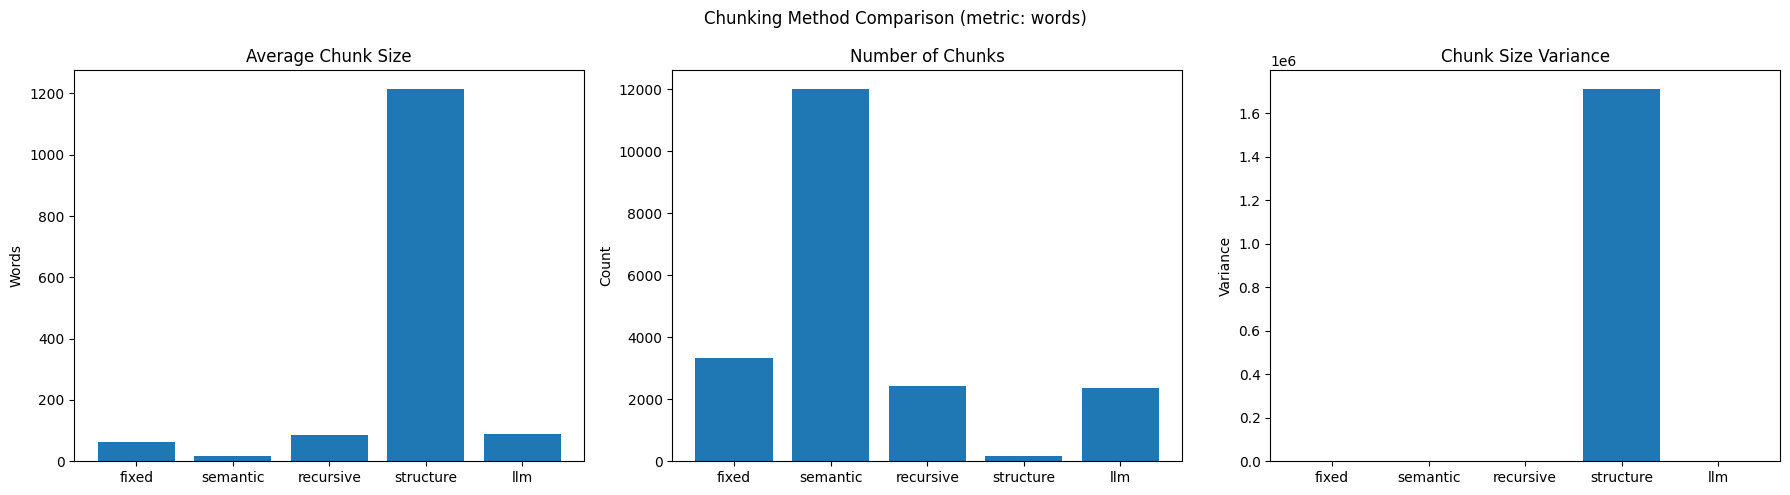

/tmp/ipython-input-917683134.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


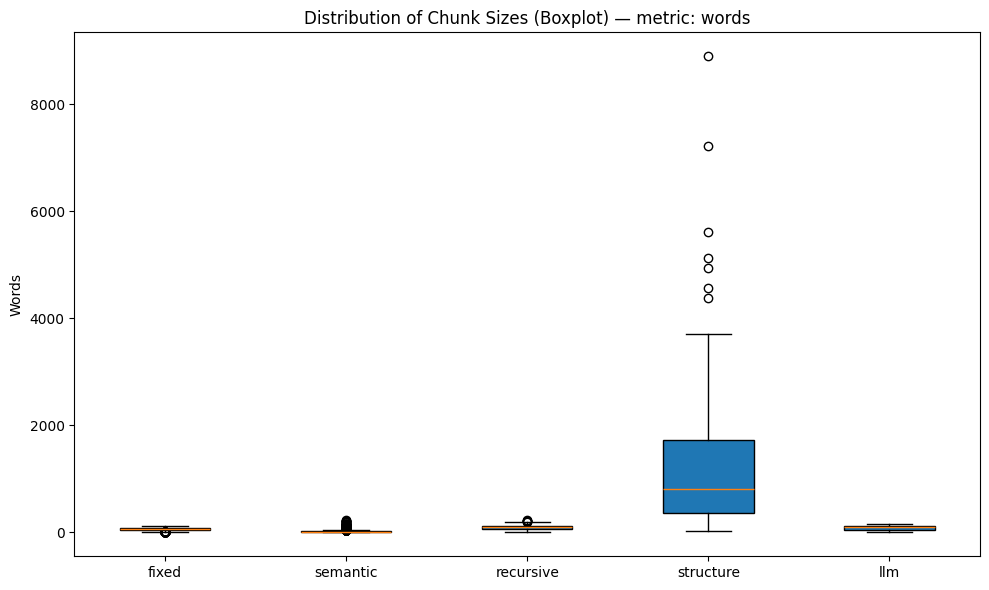

In [ ]:


# ---- Bar Plots (use the computed df, no hardcoding) ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(df["Method"], df["Avg Chunk Size"])
axes[0].set_title("Average Chunk Size")
axes[0].set_ylabel({"chars":"Characters","words":"Words","tokens":"Tokens"}[METRIC])

axes[1].bar(df["Method"], df["Num Chunks"])
axes[1].set_title("Number of Chunks")
axes[1].set_ylabel("Count")

axes[2].bar(df["Method"], df["Size Variance"])
axes[2].set_title("Chunk Size Variance")
axes[2].set_ylabel("Variance")

plt.suptitle(f"Chunking Method Comparison (metric: {METRIC})")
plt.tight_layout()
plt.show()

# ---- Boxplot from raw chunk sizes (no hardcoding) ----
def extract_sizes(chunks, metric: str):
    return [_size_val(c, metric) for c in chunks]

sizes_fixed     = extract_sizes(chunked_pages, METRIC)
sizes_semantic  = extract_sizes(semantic_chunked_pages, METRIC)
sizes_recursive = extract_sizes(recursive_chunked_pages, METRIC)
sizes_structure = extract_sizes(structure_chunked_pages, METRIC)
sizes_llm       = extract_sizes(llm_chunked_pages, METRIC)

plt.figure(figsize=(10,6))
plt.boxplot(
    [sizes_fixed, sizes_semantic, sizes_recursive, sizes_structure, sizes_llm],
    labels=["fixed", "semantic", "recursive", "structure", "llm"],
    patch_artist=True
)
plt.title(f"Distribution of Chunk Sizes (Boxplot) — metric: {METRIC}")
plt.ylabel({"chars":"Characters","words":"Words","tokens":"Tokens"}[METRIC])
plt.tight_layout()
plt.show()


Structure-based chunking → Produced the largest chunks, fewer in number, but with very high variance.

Best for capturing entire sections/chapters, less balanced for downstream models.

Semantic chunking → Produced very small chunks and the highest number of chunks.
Preserves fine-grained context, but risks over-fragmentation.

Fixed-size chunking → Produced consistent, moderate chunks  with low variance.
Predictable sizing, but ignores semantic boundaries.

Recursive chunking → A balanced approach, moderate variance, and reasonable number of chunks.
Good compromise between coherence and consistency.

LLM chunking → Produced moderate number of chunks with moderate variance, but required highest computational time.